In [3]:
pip install scikit-learn 

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 4.4 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 KB 4.9 MB/s eta 0:00:00 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchvision import models

# Define the number of classes (change based on your dataset)
num_classes = 10  # Adjust based on your dataset

# Load Model (Ensure correct architecture)
model = models.resnet18(weights=None)  # Use None instead of `pretrained=False`
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Modify last layer

# Try loading the model weights
checkpoint_path = "./model/df_model.pt"

try:
    checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))
    
    if "state_dict" in checkpoint:  # Case 1: Model saved as `torch.save(model.state_dict())`
        model.load_state_dict(checkpoint["state_dict"])
    elif isinstance(checkpoint, dict):  # Case 2: If checkpoint is a dict, assume state_dict format
        model.load_state_dict(checkpoint)
    else:  # Case 3: Model was saved using `torch.save(model)`
        model = checkpoint  # Directly use the loaded model

    print("✅ Model loaded successfully!")

except Exception as e:
    print(f"❌ Error loading model: {e}")
    exit()

# Set model to evaluation mode
model.eval()

# Define Image Transformations (Modify based on your dataset)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Test Dataset (Replace with actual dataset path)
test_dataset_path = "./dataset/test"  # Change to your dataset directory
try:
    test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    print(f"✅ Loaded test dataset with {len(test_dataset)} images.")

except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    exit()

# Initialize Lists for Evaluation Metrics
y_true = []
y_pred = []

# Evaluate Model on CPU
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get class with highest probability
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

# Compute Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted", zero_division=1)
recall = recall_score(y_true, y_pred, average="weighted", zero_division=1)
f1 = f1_score(y_true, y_pred, average="weighted", zero_division=1)

# Print Results
print("\n🔍 Model Performance Metrics:")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

# Optional: Save Metrics to a File
with open("model_evaluation.txt", "w") as f:
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1 Score: {f1:.4f}\n")

print("📁 Evaluation results saved to 'model_evaluation.txt'.")


❌ Error loading model: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "l

NameError: name 'test_loader' is not defined

/home/imtiyaz/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/imtiyaz/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Original Image: Real (Confidence: 0.33)
Adversarial Image: Real (Confidence: 0.38)


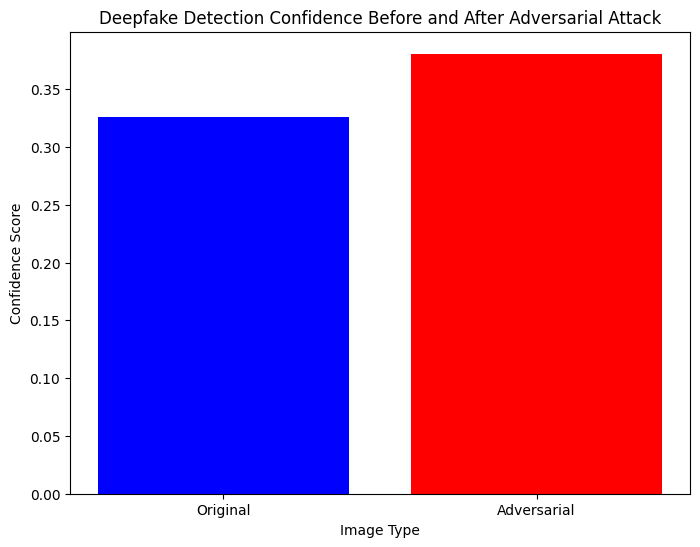

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import torchvision.models as models
import matplotlib.pyplot as plt

def load_model(model_path):
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 2)
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    return model

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

def detect_deepfake(model, image_tensor):
    with torch.no_grad():
        output = model(image_tensor)
        probability = torch.nn.functional.softmax(output, dim=1)[0][1].item()  # Fake class confidence
        return "Fake" if probability > 0.5 else "Real", probability

def add_adversarial_noise(image_tensor, model, epsilon=0.02):
    image_tensor.requires_grad = True
    output = model(image_tensor)
    loss = nn.CrossEntropyLoss()(output, torch.tensor([1]))  # Targeting fake class
    model.zero_grad()
    loss.backward()
    perturbed_image = image_tensor + epsilon * image_tensor.grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image.detach()

def plot_confidence_graph(original_confidence, adversarial_confidence):
    plt.figure(figsize=(8, 6))
    plt.bar(['Original', 'Adversarial'], [original_confidence, adversarial_confidence], color=['blue', 'red'])
    plt.xlabel('Image Type')
    plt.ylabel('Confidence Score')
    plt.title('Deepfake Detection Confidence Before and After Adversarial Attack')
    plt.show()

if __name__ == "__main__":
    model_path = "./model/df_model.pt"  # Change to your model path
    image_path = "test.png"  # Change to your test image path
    
    model = load_model(model_path)
    image_tensor = preprocess_image(image_path)
    
    # Detect deepfake before modification
    label, confidence = detect_deepfake(model, image_tensor)
    print(f"Original Image: {label} (Confidence: {confidence:.2f})")
    
    # Generate adversarial image
    adversarial_image = add_adversarial_noise(image_tensor, model)
    label_adv, confidence_adv = detect_deepfake(model, adversarial_image)
    print(f"Adversarial Image: {label_adv} (Confidence: {confidence_adv:.2f})")
    
    # Plot the confidence graph
    plot_confidence_graph(confidence, confidence_adv)
    
    # Convert adversarial image tensor back to image
    adv_image_np = adversarial_image.squeeze(0).permute(1, 2, 0).numpy()
    adv_image_np = (adv_image_np * 255).astype(np.uint8)
    cv2.imwrite("adversarial_image.jpg", adv_image_np)
